<a href="https://colab.research.google.com/github/ram130849/object_detection_using_faster_rcnn/blob/main/Object_Detection_Using_Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U opencv-python
!pip install -q -U albumentations
!pip install -q -U bounding-box

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.9/164.9 KB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 321435, done.
remote: Counting objects: 100% (4457/4457), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 321435 (delta 4242), reused 4318 (delta 4110), pack-reused 316978
Receiving objects: 100% (321435/321435), 652.01 MiB | 17.28 MiB/s, done.
Resolving deltas: 100% (295616/295616), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import utils
from torch.utils.data import DataLoader,Dataset
from skimage import io, transform
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tqdm
from torchvision.models import resnet101,ResNet101_Weights
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import time
import shutil
from engine import train_one_epoch, evaluate
import utils
import albumentations as A
from albumentations.pytorch import ToTensorV2
from bounding_box import bounding_box as bb
from PIL import Image

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/ExDark/ExDark.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/ExDark/Motorbike/2017_07361.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2017_07361.jpg  
  inflating: /content/ExDark/Motorbike/2015_06160.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_06160.jpg  
  inflating: /content/ExDark/Motorbike/2015_05864.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_05864.jpg  
  inflating: /content/ExDark/Motorbike/2015_05870.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_05870.jpg  
  inflating: /content/ExDark/Motorbike/2015_05858.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_05858.jpg  
  inflating: /content/ExDark/Motorbike/2015_05874.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_05874.jpg  
  inflating: /content/ExDark/Motorbike/2015_05860.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_05860.jpg  
  inflating: /content/ExDark/Motorbike/2015_05848.jpg  
  inflating: /content/__MACOSX/E

In [ ]:
!unzip '/content/gdrive/MyDrive/ExDark_Annno.zip' -d '/content/gdrive/MyDrive'

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05787.jpg.txt  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark_Annno/Motorbike/._2015_05787.jpg.txt  
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05797.jpg.txt  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark_Annno/Motorbike/._2015_05797.jpg.txt  
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05933.jpg.txt  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark_Annno/Motorbike/._2015_05933.jpg.txt  
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05923.jpg.txt  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark_Annno/Motorbike/._2015_05923.jpg.txt  
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05951.jpg.txt  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark_Annno/Motorbike/._2015_05951.jpg.txt  
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05829.jpg.txt  
  i

In [6]:
BATCH_SIZE=10
num_epochs=5
lr=0.001
class_size=13
# to train on gpu if selected.
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
import math

'''
    x = ((width- kernel_size +2P) /S )+1
    where P = padding
          S = strides
'''

# S=2,P=1,kernel_size=3

block1 = 224
pool1 = math.ceil((block1-3)/2+1)
print(pool1)


block2 = pool1
pool2 =math.ceil((block2-3)/2 +1)
print(pool2)


block3=pool2
pool3 =math.ceil((block3-3)/2 +1)
print(pool3)


block4=pool3
pool4 =math.ceil((block4-3)/2 +1)
print(pool4)


block5=pool4
pool5 =math.ceil((block5-3)/2 +1)
print(pool5)


flatten= pool5 * pool5 * 512
print(f'After flatten:: {flatten}')

112
56
28
14
7
After flatten:: 25088


In [8]:
class_dict = {1:'Bicycle',2:'Boat',3:'Bottle',4:'Bus',5:'Car',6:'Cat',7:'Chair',8:'Cup',9:'Dog',10:'Motorbike',11:'People',12:'Table'}
total_dict = {0:'BackGround',1:'Bicycle',2:'Boat',3:'Bottle',4:'Bus',5:'Car',6:'Cat',7:'Chair',8:'Cup',9:'Dog',10:'Motorbike',11:'People',12:'Table'}
light_dict = {1:'Low',2:'Ambient',3:'Object',4:'Single',5:'Weak',6:'Strong',7:'Screen',8:'Window',9:'Shadow',10:'Twilight'}
in_out_dict = {1:'Indoor',2:'Outdoor'}
train_val_test = {1:'train',2:'val',3:'test'}

In [9]:
classes = [val.lower() for val in list(class_dict.values())]
print(list(class_dict.keys())[list(class_dict.values()).index('Bicycle')])

1


In [10]:
df = pd.read_csv('/content/imageclasslist.txt',sep=' ',header=None,skiprows=1)
df.columns = ['Name','Class','Light','In/Out','Train/Val/Test']

In [11]:
df.loc[df.Class==1,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[1] + '/' +  df['Name']
df.loc[df.Class==2,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[2] + '/' +  df['Name']
df.loc[df.Class==3,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[3] + '/' +  df['Name']
df.loc[df.Class==4,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[4] + '/' +  df['Name']
df.loc[df.Class==5,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[5] + '/' +  df['Name']
df.loc[df.Class==6,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[6] + '/' +  df['Name']
df.loc[df.Class==7,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[7] + '/' +  df['Name']
df.loc[df.Class==8,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[8] + '/' +  df['Name']
df.loc[df.Class==9,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[9] + '/' +  df['Name']
df.loc[df.Class==10,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[10] + '/' + df['Name']
df.loc[df.Class==11,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[11] + '/' +df['Name']
df.loc[df.Class==12,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[12] + '/' +df['Name']

In [12]:
print(df.head(10))

                                                Name  Class  Light  In/Out  \
0  /content/gdrive/MyDrive/ExDark/Bicycle/2015_00...      1      2       1   
1  /content/gdrive/MyDrive/ExDark/Bicycle/2015_00...      1      6       2   
2  /content/gdrive/MyDrive/ExDark/Bicycle/2015_00...      1      5       2   
3  /content/gdrive/MyDrive/ExDark/Bicycle/2015_00...      1      3       2   
4  /content/gdrive/MyDrive/ExDark/Bicycle/2015_00...      1      6       2   
5  /content/gdrive/MyDrive/ExDark/Bicycle/2015_00...      1      6       2   
6  /content/gdrive/MyDrive/ExDark/Bicycle/2015_00...      1      2       2   
7  /content/gdrive/MyDrive/ExDark/Bicycle/2015_00...      1      6       2   
8  /content/gdrive/MyDrive/ExDark/Bicycle/2015_00...      1      6       2   
9  /content/gdrive/MyDrive/ExDark/Bicycle/2015_00...      1      5       2   

   Train/Val/Test  
0               1  
1               1  
2               1  
3               1  
4               1  
5               1  
6

In [13]:
train_val_test_count = df['Train/Val/Test'].value_counts().rename_axis('train_val_test')
train_count = train_val_test_count[1] 
val_count = train_val_test_count[2]
test_count = train_val_test_count[3]
print('train,val,test:',train_count,val_count,test_count)
train_count = train_count + val_count
test_count = test_count

train,val,test: 3000 1800 2563


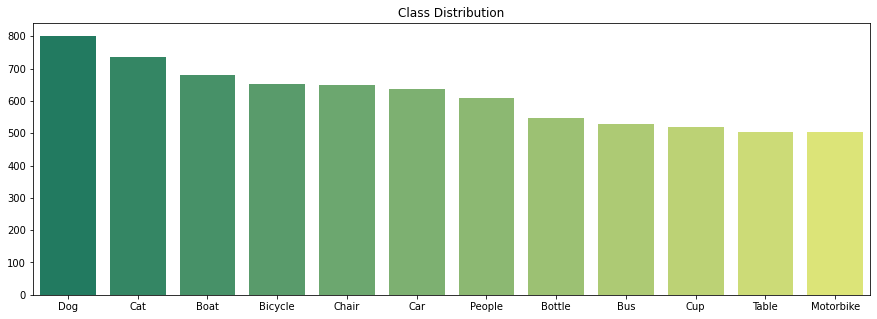

In [ ]:
class_labels = dict(df['Class'].value_counts())
labels = []
count = []
for i,j in class_labels.items():
    labels.append(class_dict[i])
    count.append(j)
plt.figure(figsize=(15,5))
sns.barplot(x=labels,y=count,palette='summer')
plt.title('Class Distribution')
plt.show()

In [ ]:
def get_class_analysis(label):
    global df
    df1 = df[df['Class']==label]
    in_out = dict(df1['In/Out'].value_counts())
    light_cond = dict(df1['Light'].value_counts())
    in_out_label =[]
    in_out_cnt =[]
    for i,j in in_out.items():
        in_out_label.append(in_out_dict[i])
        in_out_cnt.append(j)
    light_label = []
    light_cnt = []
    for i,j in light_cond.items():
        light_label.append(light_dict[i])
        light_cnt.append(j)
    print('In/Out Distribution:',in_out_label,in_out_cnt)
    print('Lightning Condt Distribution:',light_label,light_cnt)
    fig,axis = plt.subplots(2,1,figsize=(10,10))
    axis1 = sns.barplot(x=in_out_label,y=in_out_cnt,ax=axis[0])
    axis1.set_title('Indoor/outdoor Distribution')
    axis2 = sns.barplot(x=light_label,y=light_cnt,ax=axis[1])
    axis2.set_title('Lighting Condition Distribution')
    plt.show()

In [ ]:
# get_class_analysis(1)

In [ ]:
# get_class_analysis(2)

In [ ]:
# get_class_analysis(3)

In [ ]:
def plot_sample_images(label,n):
      images = []
      light = []
      global df
      df2 = df[df['Class']==label]

      for i in range(1,11):
          temp = list(df2[df2['Light']==i]['Name'])[0:n]
          if(len(temp)>2):
              for j in temp:
                  light.append(i)
                  images.append(j)

      fig, ax = plt.subplots(len(images)//n,n,figsize=(15,30),gridspec_kw={'wspace':0.01,'hspace':0.1})
      ax = ax.ravel()

      for i, img in enumerate(images):
          im_org = cv2.imread(img)
          try:
              im_resized = cv2.resize(im_org,(300,300),interpolation=cv2.INTER_LINEAR)
          except:
              continue
          ax[i].imshow(cv2.cvtColor(im_resized,cv2.COLOR_BGR2RGB),aspect='auto')
          ax[i].set_axis_off()
          ax[i].set_xlim(ax[i].get_xlim())
          ax[i].set_ylim(ax[i].get_ylim())
          ax[i].set_title(class_dict[label] + "/" + light_dict[light[i]])
      
      plt.show()

In [ ]:
# plot_sample_images(5,3)

In [ ]:
os.chdir('/content/gdrive/MyDrive/ExDark_Annno')
DIRS = os.listdir(os.getcwd())
print(DIRS)

['Cat', 'Car', 'Cup', 'Dog', 'Boat', 'Chair', 'Bus', 'Motorbike', 'Table', 'People', 'Bicycle', 'Bottle', 'vgg16_model.pt']


In [ ]:
# for dir in DIRS:
#     dir = '/content/gdrive/MyDrive/ExDark_Annno'+ '/' + dir
#     if(os.path.isdir(dir)):
#         os.chdir(dir)
#         for filename in tqdm.tqdm(os.listdir(os.getcwd())):
#             filename_str = str.split(filename, ".")[0]
#             if filename.endswith(".txt"):
#                   annotations = []
#                   with open(filename) as f:
#                       for idx,val in enumerate(f):
#                           if(idx==0):
#                             continue
#                           class_label = val.split()[0]
#                           if(class_label.lower() not in classes):
#                             continue
#                           val = val.replace(class_label,str(list(class_dict.keys())[list(class_dict.values()).index(class_label)]))
#                           labels = val.split()
#                           coords = np.asarray([float(labels[1]),float(labels[2]),float(labels[3]),float(labels[4])])
#                           labels[1],labels[2],labels[3],labels[4] = coords[0], coords[1], coords[2], coords[3]
#                           new_val = str(labels[0]) + "," + str(labels[1]) + "," +str(labels[2]) + "," + str(labels[3]) + "," + str(labels[4])
#                           val = val.replace(val, new_val)
#                           annotations.append(val)
#                       f.close()
#                   with open(filename,'w') as outfile:
#                       for val in annotations:
#                           outfile.write(val)
#                           outfile.write('\n') 
#                       outfile.close()       
#         os.chdir('..')

100%|██████████| 547/547 [00:02<00:00, 199.50it/s]


In [ ]:
data = []
labels_arr = []
bboxes_arr = []
imagePaths = []

In [ ]:
image_list = df['Name'].to_list()
imagePaths.extend(image_list)

In [ ]:
for dir in DIRS:
    dir = '/content/gdrive/MyDrive/ExDark_Annno'+ '/' + dir
    if(os.path.isdir(dir)):
        os.chdir(dir)
        for filename in tqdm.tqdm(os.listdir(os.getcwd())):
            filename_str = str.split(filename, ".")[0]
            if filename.endswith(".txt"):
                  annotations = []
                  coords = []
                  with open(filename) as f:
                      for idx,val in enumerate(f):
                          val_list = list(val.strip().split(','))
                          annotations.append(float(val_list[0]))
                          # annotations.append(class_dict[val_list[0]])
                          coords.append([float(val) for val in val_list[1:]])
                      f.close()
                  if(len(coords)>0 and len(annotations)>0):
                        bboxes_arr.append(coords)
                        labels_arr.append(annotations)
        os.chdir('..')

100%|██████████| 547/547 [00:00<00:00, 1768.83it/s]


In [ ]:
bboxes = tuple(tuple(map(tuple,bbox)) for bbox in bboxes_arr)

In [ ]:
# labels = np.zeros([len(labels_arr),len(max(labels_arr,key = lambda x: len(x)))])
# for i,j in enumerate(labels_arr):
#     labels[i][0:len(j)] = j

In [ ]:
# bboxes = np.ones([len(bboxes_arr),58,4])
# for i,bb in enumerate(bboxes_arr):
#     bboxes[i][0:len(bb)] = np.array([np.array(b) for b in bb])

In [ ]:
data = np.asarray(data)
imagePaths = np.asarray(imagePaths)
labels = np.asarray([np.asarray(labels) for labels in labels_arr])
# bboxes = np.asarray([np.asarray(bb) for bb in bboxes_arr])

<ipython-input-22-81ca1ba0f5a3>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.asarray([np.asarray(labels) for labels in labels_arr])


In [ ]:
# labels

In [ ]:
# with open('/content/gdrive/MyDrive/image_data.npy', 'wb') as f:
#     np.save(f, data)

In [ ]:
with open('/content/gdrive/MyDrive/image_bboxes.npy', 'wb') as f:
    np.save(f, bboxes)

/usr/local/lib/python3.9/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
# with open('/content/gdrive/MyDrive/image_labels.npy', 'wb') as f:
#      np.save(f, labels)

In [ ]:
# with open('/content/gdrive/MyDrive/image_paths.npy', 'wb') as f:
#     np.save(f, imagePaths)

In [ ]:
# with open('/content/gdrive/MyDrive/ExDark/image_data.npy', 'rb') as f:
#     data = np.load(f)

In [14]:
with open('/content/gdrive/MyDrive/image_bboxes.npy', 'rb') as g:
    bboxes = np.load(g,allow_pickle=True)

In [15]:
with open('/content/gdrive/MyDrive/image_labels.npy', 'rb') as f:
    labels = np.load(f,allow_pickle=True)

In [16]:
with open('/content/gdrive/MyDrive/image_paths.npy', 'rb') as f:
    imagePaths = np.load(f,allow_pickle=True)

In [ ]:
# bboxes

In [ ]:
# labels

In [ ]:
# data

In [ ]:
torch.manual_seed(1)

In [17]:
def get_transforms(phase):
    list_transforms = []
    # list_transforms.extend([transforms.Resize((224,244))])
    if phase == 'train':
        list_transforms.extend([
                transforms.RandomHorizontalFlip(p=0.5)
                ])
    list_transforms.extend([transforms.ToTensor(),
                ])
    list_transforms.extend([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])])
    list_trfms = transforms.Compose(list_transforms)
    
    return list_trfms
    # trn_tfms = A.Compose([
    #       # A.ToGray(p=0.2),
    #       A.HorizontalFlip(),
    #       A.Rotate(limit=60),
    #       # A.CLAHE(),
    #       A.Sharpen(),
    #       A.Perspective(),
    #       A.ToFloat(max_value=255.0, always_apply=True),
    #       ToTensorV2(always_apply=True),
    #       ], p=1., bbox_params=A.BboxParams(format='albumentations',label_fields=['class_labels']))

    # val_tfms = A.Compose([
    #     A.ToFloat(max_value=255.0, always_apply=True),
    #     ToTensorV2(always_apply=True),   
    #     ], p=1., bbox_params=A.BboxParams(format='albumentations',label_fields=['class_labels']))

    # return trn_tfms if(phase == 'train') else val_tfms

In [18]:
class ExDark(Dataset):
    def __init__(self,data,transform):
        self.data = data
        self.transform = get_transforms(transform)
        
    def __len__(self):
        return len(self.data[0])
        
    def __getitem__(self,idx):
        image_idx = self.data[0][idx]
        labels = torch.tensor(self.data[1][idx], dtype=torch.int64)
        bbox = torch.tensor(self.data[2][idx])
        image = cv2.imread(image_idx, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # image = cv2.resize(image, (600, 600))
        # image /= 255.0

        wt,ht,c = image.shape

        width = bbox[:,2]
        height = bbox[:,3]

        bbox[:, 2] = bbox[:, 0] + bbox[:, 2]
        bbox[:, 3] = bbox[:, 1] + bbox[:, 3]

        bbox[:,0] = (bbox[:,0]/width)
        bbox[:,1] = (bbox[:,1]/height)
        bbox[:,2] = (bbox[:,2]/width)
        bbox[:,3] = (bbox[:,3]/height)
        
        area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # labels = torch.ones((labels.shape[0],), dtype=torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((labels.shape[0],), dtype=torch.int64)
        
        # image = torch.permute(torch.tensor(image), (2, 0, 1)).numpy()

        target = {}
        target['boxes'] = bbox
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transform:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }

            # sample = self.transform(image=sample['image'],bboxes=sample['bboxes'], class_labels=sample['labels'])
            # image = sample['image']
            image = self.transform(Image.fromarray(sample['image'].astype(np.uint8)))
            target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                    zip(*target['boxes'])))).permute(1, 0) 

        return (image, target)

In [19]:
train_count = 4800
test_count = 2563

In [20]:
train = ExDark((imagePaths[:train_count],labels[:train_count],bboxes[:train_count]),'train')
test = ExDark((imagePaths[train_count:train_count+test_count],labels[train_count:train_count+test_count],bboxes[train_count:train_count+test_count]),'test')

train_loader = DataLoader(train,batch_size=BATCH_SIZE,shuffle=True,collate_fn=utils.collate_fn)
test_loader = DataLoader(test,batch_size=BATCH_SIZE,shuffle=False,collate_fn=utils.collate_fn)

In [ ]:
# images, targets= next(iter(train_loader))
# images = list(image.to(device) for image in images)
# targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# plt.figure(figsize=(20,20))
# for i, (image, target) in enumerate(zip(images, targets)):
#     plt.subplot(5,5, i+1)
#     boxes = np.asarray(targets[i]['boxes'].cpu().numpy(), dtype=int)
#     sample = images[i].cpu().numpy().transpose(2,1,0).astype(np.uint8)
#     print('sample shape:',type(sample))
#     # image = cv2.imread(sample)
#     names = targets[i]['labels'].cpu().numpy().astype(np.int64)
#     for i,box in enumerate(boxes):
#         cv2.rectangle(np.array(sample,dtype=np.uint8),(int(box[0]), int(box[1])),(int(box[2]), int(box[3])), 2)
#         cv2.putText(np.array(sample,dtype=np.uint8), classes[names[i]], (int(box[0]),int(box[1])+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)  

#     plt.axis('off')
#     plt.imshow(np.array(sample,dtype=np.uint8))

In [21]:
from torchvision.models.detection.backbone_utils import mobilenet_backbone

backbone = mobilenet_backbone(backbone_name = "mobilenet_v2", weights='MobileNet_V2_Weights.IMAGENET1K_V1',fpn=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [22]:
anchor_generator = AnchorGenerator(
    sizes=(32, 64, 128), aspect_ratios=(0.5, 1.0, 2.0)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=13,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
model = model.to(device)

In [ ]:
# objectDetector = Object_Detector(resnet, len(class_dict))

In [ ]:
# classLossFunc = nn.CrossEntropyLoss()
# bboxLossFunc = nn.MSELoss()

In [23]:
# opt = torch.optim.Adam(objectDetector.parameters(), lr=0.001)
# model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.005,weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [24]:
# helper functions to save best model

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if(is_best):
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    cpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(cpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(cpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = cpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, cpoint['epoch'], valid_loss_min.item()

In [25]:
num_epochs = 10
train_loss_min = 0
total_train_loss = []
grad_clip = True
checkpoint_path = '/content/gdrive/MyDrive/ExDark/chkpoint'
best_model_path = '/content/gdrive/MyDrive/ExDark/chkpoint/best/bestmodel_may12.pt'

In [26]:
@torch.no_grad()
def evaluate_loss(model, data_loader, device):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)

    return metric_logger

In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = []
    model.train()
    # print(f'Epoch :{epoch + 1}')
    # for (images, targets) in train_loader:
    #     images = [image.to(device) for image in images]
    #     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    #     loss_dict = model(images, targets)
    #     losses = sum(loss for loss in loss_dict.values())
    #     train_loss.append(losses.item()) 
    #     # Gradient clipping
    #     if grad_clip: 
    #         nn.utils.clip_grad_value_(model.parameters(), grad_clip)   
    #     optimizer.zero_grad()
    #     losses.backward()
    #     optimizer.step()
    metric_logger = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    print('metric_logger:',metric_logger)
    # print('metric loss:',metric_logger['loss'])
    lr_scheduler.step()
    # epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(0)
    print(f'Epoch train loss is {0}')
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'train_loss_min': 0,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    # if(0 < train_loss_min):
    #         # save checkpoint as best model
    #         save_ckp(checkpoint, True, checkpoint_path, best_model_path)
    #         train_loss_min = 0
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
evaluate(model, test_loader, device=device)

Epoch: [0]  [  0/480]  eta: 0:11:37  lr: 0.000015  loss: 0.2952 (0.2952)  loss_classifier: 0.2441 (0.2441)  loss_box_reg: 0.0005 (0.0005)  loss_objectness: 0.0054 (0.0054)  loss_rpn_box_reg: 0.0452 (0.0452)  time: 1.4540  data: 0.8644  max mem: 5842
Epoch: [0]  [ 10/480]  eta: 0:08:07  lr: 0.000120  loss: 0.2368 (0.2141)  loss_classifier: 0.1861 (0.1623)  loss_box_reg: 0.0001 (0.0002)  loss_objectness: 0.0054 (0.0055)  loss_rpn_box_reg: 0.0453 (0.0460)  time: 1.0381  data: 0.4867  max mem: 5842
Epoch: [0]  [ 20/480]  eta: 0:07:10  lr: 0.000224  loss: 0.1880 (0.2024)  loss_classifier: 0.1371 (0.1515)  loss_box_reg: 0.0000 (0.0002)  loss_objectness: 0.0054 (0.0055)  loss_rpn_box_reg: 0.0453 (0.0453)  time: 0.9092  data: 0.3664  max mem: 5850
Epoch: [0]  [ 30/480]  eta: 0:06:46  lr: 0.000328  loss: 0.1852 (0.1953)  loss_classifier: 0.1325 (0.1447)  loss_box_reg: 0.0000 (0.0001)  loss_objectness: 0.0054 (0.0055)  loss_rpn_box_reg: 0.0441 (0.0449)  time: 0.8297  data: 0.2943  max mem: 5850


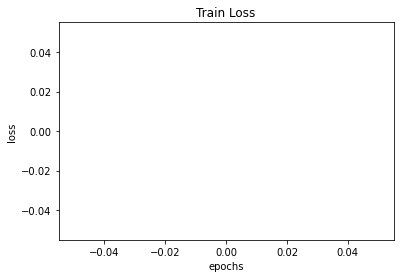

In [ ]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [ ]:
# pick one image from the test set
img, target = test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

AssertionError: ignored

In [ ]:
# class VGG16Net(nn.Module):
#     def __init__(self):
#         super(VGG16Net,self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1)
#         self.conv2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1)
#         self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
#         self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1)
#         self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
#         self.conv6 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
#         self.conv7 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
#         self.conv8 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1)
#         self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
#         self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
#         self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
#         self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
#         self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc14 = nn.Linear(25088, 4096)
#         self.fc15 = nn.Linear(4096,4096)
#         self.fc16 = nn.Linear(4096,10)
        
#     def forward(self,x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.maxpool(x)
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.maxpool(x)
#         x = F.relu(self.conv5(x))
#         x = F.relu(self.conv6(x))
#         x = F.relu(self.conv7(x))
#         x = self.maxpool(x)
#         x = F.relu(self.conv8(x))
#         x = F.relu(self.conv9(x))
#         x = F.relu(self.conv10(x))
#         x = self.maxpool(x)
#         x = F.relu(self.conv11(x))
#         x = F.relu(self.conv12(x))
#         x = F.relu(self.conv13(x))
#         x = self.maxpool(x)
#         x = x.reshape(x.shape[0], -1)
#         x = F.relu(self.fc14(x))
#         x = F.dropout(x, 0.5)
#         x = F.relu(self.fc15(x))
#         x = F.dropout(x, 0.5)
#         x = self.fc16(x)

#         return x

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
# model = VGG16Net() 
# model = model.to(device=device) 
# load_model = True
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr= lr) 

In [ ]:
# torch.save(model.state_dict(), "vgg16_model.pt") #SAVES THE TRAINED MODEL
# model = VGG16Net()
# model.load_state_dict(torch.load("vgg16_model.pt")) #loads the trained model
# model.eval()

In [ ]:
# class Residual_Block(nn.Module):
#     def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
#         assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
#         super(Residual_Block, self).__init__()
#         self.num_layers = num_layers
#         self.expansion = 4
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         if(self.num_layers > 34):
#             self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         else:
#             # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
#             self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
#         self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
#         self.relu = nn.ReLU()
#         self.identity_downsample = identity_downsample

#     def forward(self, x):
#         identity = x
#         if self.num_layers > 34:
#             x = self.conv1(x)
#             x = self.bn1(x)
#             x = self.relu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.conv3(x)
#         x = self.bn3(x)

#         if(self.identity_downsample):
#             identity = self.identity_downsample(identity)

#         x += identity
#         x = self.relu(x)
#         return x

In [ ]:
# class ResNet(nn.Module):
#     def __init__(self, no_layers, block, image_channels, num_classes):
#         assert no_layers in [18, 34, 50, 101, 152], ' Number of layers has to be 18, 34, 50, 101, or 152'
#         super(ResNet, self).__init__()
#         self.expansion = 4
#         layers = [3, 4, 23, 3]
#         self.in_channels = 64
#         self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 56

#         # ResNetLayers
#         self.layer1 = self.make_layers(no_layers, block, layers[0], intermediate_channels=64, stride=1)
#         self.layer2 = self.make_layers(no_layers, block, layers[1], intermediate_channels=128, stride=2)
#         self.layer3 = self.make_layers(no_layers, block, layers[2], intermediate_channels=256, stride=2)
#         self.layer4 = self.make_layers(no_layers, block, layers[3], intermediate_channels=512, stride=2)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * self.expansion, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.reshape(x.shape[0], -1)
#         x = self.fc(x)
#         return x

#     def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
#         layers = []

#         identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
#                                             nn.BatchNorm2d(intermediate_channels*self.expansion))
#         layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
#         self.in_channels = intermediate_channels * self.expansion # 256
#         for i in range(num_residual_blocks - 1):
#             layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
#         return nn.Sequential(*layers)

In [ ]:
# resnet = resnet101(pretrained=True)

# resnet.out_channels = 1280
# resnet.fc = nn.Linear(512 * 4, 12)
# for param in resnet.parameters():
# 	  param.requires_grad = False

In [ ]:
# class Object_Detector(Module):
#     def __init__(self,base_model,no_classes):
#         super(Object_Detector,self).__init__()
#         self.base_model = base_model
#         # print(self.base_model.eval())
#         self.no_classes = no_classes
#         self.regressor = Sequential(
#             Linear(self.base_model.fc.in_features,128),
#             ReLU(),
#             Linear(128,64),
#             ReLU(),
#             Linear(64,32),
#             ReLU(),
#             Linear(32,4)
#         )
#         self.classifier = Sequential(
#             Linear(self.base_model.fc.in_features,512),
#             ReLU(),
#             Dropout(),
#             Linear(512,256),
#             ReLU(),
#             Dropout(),
#             Linear(256,self.no_classes)
#         )
#         ### The final step of the initialization is to make the base model’s fully connected layer into an Identity layer,
#         ### which means it’ll mirror the outputs produced by the convolution block right before it
#         self.base_model.fc = Identity()

#     def forward(self,x):
#         features = self.base_model(x)
#         b_boxes = self.regressor(features)
#         class_logits = self.classifier(features)

#         return (b_boxes,class_logits)